# kNN - Find Similar Images

Taken from [here](https://www.kaggle.com/cdeotte/rapids-cuml-knn-find-duplicates)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import math
from glob import glob
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.models import load_model, Model, Sequential

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64
LOAD_EMBEDDINGS = False
PATH_TO_EMBEDDINGS = "embeddings"

# Create Dataset

In [4]:
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, 1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image/255., tf.float32)
    return image, label

In [5]:
TRAIN_PATH = "../data/interim/train/"
TEST_PATH = "../data/interim/test/"

In [6]:
train = glob(TRAIN_PATH+"*.png")
test = glob(TEST_PATH+"*.png")

In [7]:
# sorting by image numbers
train.sort(key=lambda f: int(re.sub('\D', '', f)))
test.sort(key=lambda f: int(re.sub('\D', '', f)))

In [8]:
train_file_nums = [int(x.split("/")[-1].split(".")[0]) for x in train]
test_file_nums = [int(x.split("/")[-1].split(".")[0]) for x in test]

In [10]:
train_df = pd.read_csv(TRAIN_PATH+"train_data.csv")
train_labels = train_df.loc[train_df["tag"].isin(train_file_nums)].sort_values(by="tag")["label"].tolist()

test_df = pd.read_csv(TEST_PATH+"sample_submission.csv")
test_labels = test_df.loc[test_df["tag"].isin(test_file_nums)].sort_values(by="tag")["label"].tolist()

In [11]:
len(train), len(train_labels)

(394, 394)

In [12]:
len(test), len(test_labels)

(40, 40)

In [13]:
orig_train_dataset = tf.data.Dataset.from_tensor_slices((train, train_labels))
train_dataset = orig_train_dataset.map(
    preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
orig_test_dataset = tf.data.Dataset.from_tensor_slices((test, test_labels))
test_dataset = orig_test_dataset.map(
    preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
test_dataset = test_dataset.batch(BATCH_SIZE)

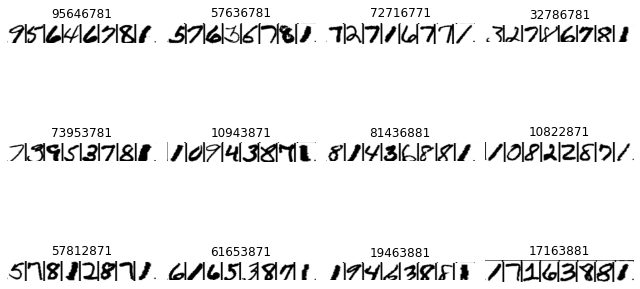

In [15]:
num_samples = 12
samples = dict(zip(train[0: num_samples], train_labels[0: num_samples]))

plt.figure(figsize=(9, 6))
for idx, (path, label) in enumerate(samples.items()):
    ax = plt.subplot(3, 4, idx + 1)
    img = cv2.imread(path)
    plt.imshow(img.astype("uint8"))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()

# Extract Image Features

We will extract image embeddings from the model trained [here](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist) using images of size `224x224`. If the variable `LOAD_EMBEDDINGS=True` then we will load them from a previous notebook version Kaggle dataset. If `LOAD_EMBEDDINGS=False`, we will extract them. We normalize our inputs by subtracting ImageNet mean of `0.449` and dividing by ImageNet standard deviation of `0.226`. This is important for image feature extraction because we are not training the EfficientNet anymore. If we were training more, then the model would correct itself if we don't normalize.

In [16]:
def get_mnist_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(28, 28, 1)))
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    model.load_weights("../data/external/model_0.h5")
    return model

In [17]:
model = get_mnist_model()

In [18]:
def build_model():
    inp = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    model = get_mnist_model()
    base = Model(inputs=model.input, outputs=model.get_layer(index=-4).output)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

## Test Image Embeddings

In [19]:
if not LOAD_EMBEDDINGS:
    model = build_model()
    embed_test = model.predict(test_dataset, verbose=1)
    np.save(f"embed_test_{IMG_SIZE}", embed_test.astype("float32"))
else:
    embed_test = np.load(PATH_TO_EMBEDDINGS + f"embed_test_{IMG_SIZE}")
print(f"Test Embeddings Shape: {embed_test.shape}")

1/1 [==============================] - 0s 2ms/step
Test Embeddings Shape: (40, 128)


## Train Image Embeddings

In [20]:
if not LOAD_EMBEDDINGS:
    model = build_model()
    embed_train = model.predict(train_dataset, verbose=1)
    np.save(f"embed_train_{IMG_SIZE}", embed_train.astype("float32"))
else:
    embed_train = np.load(PATH_TO_EMBEDDINGS + f"embed_train_{IMG_SIZE}")
print(f"Train Embeddings Shape: {embed_train.shape}")

7/7 [==============================] - 40s 6s/step
Train Embeddings Shape: (394, 128)


# kNN - Find Duplicates

## Find Duplicates

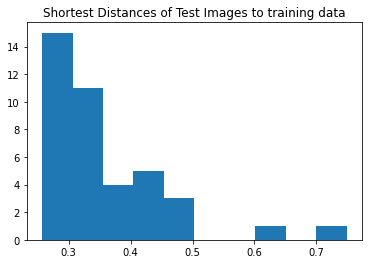

In [21]:
KNN = 3
knn = NearestNeighbors(n_neighbors=KNN)
knn.fit(embed_train)
distances, indices = knn.kneighbors(embed_test)

mm = np.min(distances, axis=1)
plt.title("Shortest Distances of Test Images to training data")
plt.hist(mm)
plt.show()

In [35]:
CUTOFF = 0.26
idx = np.where((mm<CUTOFF))[0]
print(f"There are {len(idx)} potential duplicate images that have distance < {CUTOFF}")

There are 3 potential duplicate images that have distance < 0.26


## Display Duplicates

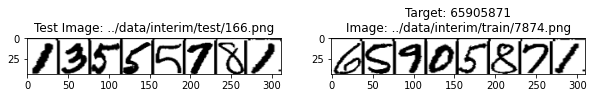

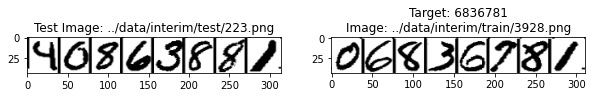

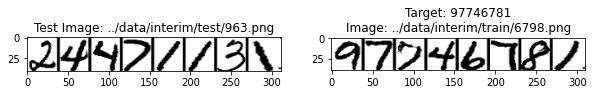

In [36]:
for k in idx:
    plt.figure(figsize=(10, 5))    
    plt.subplot(1, 2, 1)
    img = cv2.imread(test[k])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Test Image: {test[k]}")

    plt.subplot(1, 2, 2)
    img = cv2.imread(train[int(indices[k, 0])])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    t = train_labels[int(indices[k, 0])]
    plt.title(f"Target: {t}\nImage: {train[int(indices[k, 0])]}")
    
    plt.show()

**This method doesn't seem to be working, as the model is not able to correctly identify digits**